In [10]:
# Define libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os, importlib, pickle, time
import torch
import torch.optim as optim
from torchvision import transforms, io
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import pairwise_distances
import dpr_models
importlib.reload(dpr_models)

# Define run name
run_name = 'baseline'

# Check if CUDA is available
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'Use {device}')
# Check if MPS is available
#device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

# Define model configration
configs = {'lifelog_dir':'./Lifelog-6/',
           'embedding_dim':512,
           'hidden_dim':512,
           'batch_size':512,
           'epochs':10,
           'N_valid':200,
           'sensor_feats':['heart_rate(bpm)','heart_rate_conf','calories','distance',
                           'minutesAsleep','minutesAwake','minutesAfterWakeup','timeInBed','sleep_efficiency',
                           'new_lat','new_lng','semantic_name','categories','movement','city'],
           'normalization':True,
           'model_path':f'./models/{run_name}.pth',
           'configs_path':f'./models/{run_name}.pkl'}

In [4]:
# Load sensor data
lifelog_dir = configs['lifelog_dir']

df_sen = pd.read_csv(f'{lifelog_dir}/lsc22_metadata.csv', low_memory=False)
df_loc = pd.read_csv(f'{lifelog_dir}/vaisl_gps.csv', low_memory=False)
df_loc = df_loc.drop_duplicates()
df = pd.merge(df_loc, df_sen, how='left', on='minute_id', suffixes=('', '_y'))

# Fix image path
df['month'] = df['ImageID'].map(lambda x:x[0:6])
df['day'] = df['ImageID'].map(lambda x:x[6:8])
df['ImageID_full'] = lifelog_dir + '/images/' + df['month'] + '/' + df['day'] + '/' + df['ImageID']

df = df[(df['month']=='202003')]

# Check image file existence
df['image_file_exist'] = df['ImageID_full'].map(lambda x: os.path.exists(x))
df = df[df['image_file_exist']]

# Sampling data
df['local_time'] = pd.to_datetime(df['ImageID'], format='%Y%m%d_%H%M%S_000.jpg')
df_sampled = df.set_index('local_time').groupby(pd.Grouper('local_time', freq='h')).apply(lambda x: x.sample(n=min(20,len(x)), random_state=0), include_groups=False).reset_index(drop=True)

# Frequency encoding for categorical data
for col in df[configs['sensor_feats']].select_dtypes(['object']):
    df_sampled[col] = df_sampled[col].fillna('Unknown')
    df_gp = df_sampled.groupby(col)[col].count().reset_index(name=f'{col}_freq')
    df_gp[f'{col}_fe'] = df_gp[f'{col}_freq'] / df_gp[f'{col}_freq'].sum()
    df_sampled = pd.merge(df_sampled, df_gp, how='left', on=col)
    df_sampled[f'{col}_orig'] = df_sampled[col].copy()
    df_sampled[col] = df_sampled[f'{col}_fe'].copy()
    configs[col] = dict(zip(df_gp[col], df_gp[f'{col}_fe']))

sensor_data = df_sampled[configs['sensor_feats']].fillna(0.).values
sensor_data = torch.from_numpy(sensor_data.astype(np.float32)).clone()

In [5]:
# Load image data
images_list = []
for image_path in df_sampled['ImageID_full'].tolist():
    image = io.read_image(path=image_path)
    image = transforms.functional.resize(img=image, size=(224,224)).to(torch.float32)
    image = transforms.functional.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    images_list.append(image)
image_data = torch.stack(images_list, dim=0)

In [6]:
# Check shape of data
print('Image data: ', image_data.shape)
print('Snesor data:', sensor_data.shape)

Image data:  torch.Size([9005, 3, 224, 224])
Snesor data: torch.Size([9005, 15])


In [7]:
# Create a dataset class for image and sensor
class ImageSensorDataset(Dataset):
    def __init__(self, image_data, sensor_data):
        self.image_data = image_data
        self.sensor_data = sensor_data

    def __len__(self):
        return len(self.sensor_data)

    def __getitem__(self, idx):
        images = self.image_data[idx]
        sensors = self.sensor_data[idx]

        return images, sensors

N_valid = configs['N_valid']
N_train = int(len(image_data)) - N_valid
perms = np.random.permutation(len(image_data))
train_idx = perms[:N_train]
valid_idx = perms[N_train:]

train_image_data = image_data[train_idx]
valid_image_data = image_data[valid_idx]
train_sensor_data = sensor_data[train_idx]
valid_sensor_data = sensor_data[valid_idx]

train_dataset = ImageSensorDataset(train_image_data, train_sensor_data)
valid_dataset = ImageSensorDataset(valid_image_data, valid_sensor_data)
train_data_loader = DataLoader(train_dataset, batch_size=configs['batch_size'], shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=configs['batch_size'])

In [11]:
# Define DPR model
configs['sensor_avg'] = torch.mean(sensor_data, 0)
configs['sensor_std'] = torch.std(sensor_data, 0)
sensor_avg = torch.mean(sensor_data, 0)
sensor_std = torch.std(sensor_data, 0)
image_encoder = dpr_models.ImageEncoder(output_dim=configs['embedding_dim']).to(device)
sensor_encoder = dpr_models.SensorEncoder(avg=configs['sensor_avg'].to(device),
                                          std=configs['sensor_std'].to(device),
                                          input_dim=sensor_data.shape[1],
                                          hidden_dim=configs['hidden_dim'],
                                          output_dim=configs['embedding_dim'],
                                          normalization=configs['normalization']).to(device)

dpr_model = dpr_models.DPRModel(image_encoder, sensor_encoder).to(device)
optimizer = optim.Adam(dpr_model.parameters(), lr=1e-4)

criterion = dpr_models.SimilarityBasedCrossEntropy(temperature=0.5, device=device)

In [12]:
# Define evaluation metric (Mean Reciprocal Rank)
def calculate_mrr(image_embeddings, sensor_embeddings):
    image_embeddings_np = torch.cat(image_embeddings).detach().cpu().numpy()
    sensor_embeddings_np = torch.cat(sensor_embeddings).detach().cpu().numpy()
    similarities = 1 - pairwise_distances(image_embeddings_np, sensor_embeddings_np, metric='cosine')

    num_samples = similarities.shape[0]
    ranks = np.zeros(num_samples)
    
    for i in range(num_samples):
        # Rank the similarities
        sorted_indices = np.argsort(-similarities[i])
        rank = np.where(sorted_indices == i)[0][0] + 1  # +1 for 1-based rank
        ranks[i] = rank
    
    mean_rank = np.mean(ranks)
    mrr = np.mean(1 / ranks)
    
    return mean_rank, mrr

In [13]:
# Start training
df_train = pd.DataFrame()
for epoch in range(configs['epochs']):
    start = time.time()
    dpr_model.train()
    train_loss, valid_loss = 0., 0.
    train_image_embeddings, train_sensor_embeddings = [], []
    valid_image_embeddings, valid_sensor_embeddings = [], []
    for images, sensors in train_data_loader:
        # Forward pass
        image_emb, sensor_emb = dpr_model(images.to(device), sensors.to(device))

        # Calculate loss
        loss = criterion(image_emb, sensor_emb)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        train_image_embeddings.append(image_emb)
        train_sensor_embeddings.append(sensor_emb)

    dpr_model.eval()
    for images, sensors in valid_data_loader:
        # Forward pass
        image_emb, sensor_emb = dpr_model(images.to(device), sensors.to(device))
        loss = criterion(image_emb, sensor_emb)
        valid_loss += loss.item()

        valid_image_embeddings.append(image_emb)
        valid_sensor_embeddings.append(sensor_emb)

    end = time.time()
    time_diff = end - start

    # Calculate evaluation metrics (Mean Reciprocal Rank)
    train_mean_rank, train_mrr = calculate_mrr(train_image_embeddings, train_sensor_embeddings)
    valid_mean_rank, valid_mrr = calculate_mrr(valid_image_embeddings, valid_sensor_embeddings)

    result = f'Epoch [{epoch+1}/{configs["epochs"]}]'
    result += f', Train Loss: {train_loss:.4f}, Train Mean Rank: {train_mean_rank:.1f}/{len(train_image_data)}, Train MRR: {train_mrr:.4f}'
    result += f', Valid Loss: {valid_loss:.4f}, Valid Mean Rank: {valid_mean_rank:.1f}/{len(valid_image_data)}, Valid MRR: {valid_mrr:.4f}'
    result += f', Time: {time_diff:.2f}'

    res = {'epoch':[epoch+1], 'N_train':N_train, 'N_valid':N_valid,
           'train_loss':train_loss, 'train_mean_rank':train_mean_rank, 'train_mrr':train_mrr,
           'valid_loss':valid_loss, 'valid_mean_rank':valid_mean_rank, 'valid_mrr':valid_mrr}
    
    df_train = pd.concat([df_train, pd.DataFrame(res)])
    print(result)

print("Training complete.")
df_train.to_csv(f'./logs/train_log_{run_name}.csv', index=False)

# Save model
torch.save(dpr_model.state_dict(), configs['model_path'])

# Save configs
with open(configs['configs_path'], mode='wb') as f:
    pickle.dump(configs, f)

Epoch [1/10], Train Loss: 106.9346, Train Mean Rank: 2486.8/8805, Train MRR: 0.0050, Valid Loss: 4.8850, Valid Mean Rank: 45.9/200, Valid MRR: 0.1042, Time: 12.30
Epoch [2/10], Train Loss: 101.3395, Train Mean Rank: 1670.7/8805, Train MRR: 0.0072, Valid Loss: 4.7176, Valid Mean Rank: 38.4/200, Valid MRR: 0.1329, Time: 11.92
Epoch [3/10], Train Loss: 98.9277, Train Mean Rank: 1431.8/8805, Train MRR: 0.0083, Valid Loss: 4.6341, Valid Mean Rank: 34.1/200, Valid MRR: 0.1473, Time: 11.96
Epoch [4/10], Train Loss: 97.5830, Train Mean Rank: 1300.9/8805, Train MRR: 0.0103, Valid Loss: 4.5774, Valid Mean Rank: 31.2/200, Valid MRR: 0.1792, Time: 11.96
Epoch [5/10], Train Loss: 96.6534, Train Mean Rank: 1217.7/8805, Train MRR: 0.0106, Valid Loss: 4.5375, Valid Mean Rank: 29.5/200, Valid MRR: 0.1875, Time: 11.98
Epoch [6/10], Train Loss: 96.0644, Train Mean Rank: 1147.4/8805, Train MRR: 0.0113, Valid Loss: 4.5068, Valid Mean Rank: 28.2/200, Valid MRR: 0.1977, Time: 11.97
Epoch [7/10], Train Loss: 

OSError: Cannot save file into a non-existent directory: '../logs'

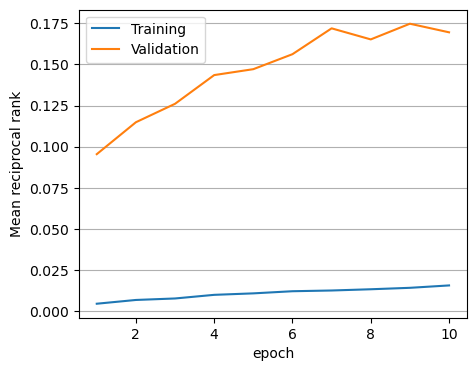

In [33]:
# Plot MRR in each epoch
fig, ax = plt.subplots(figsize=(5, 4))
sns.lineplot(data=df_train, x='epoch', y='train_mrr', label='Training')
sns.lineplot(data=df_train, x='epoch', y='valid_mrr', label='Validation')
ax.set_ylabel('Mean reciprocal rank')
plt.grid(axis='y')
plt.savefig(f'../logs/mrr_{run_name}.pdf', transparent=True, bbox_inches='tight')

In [34]:
# Test saved model and configs
with open(configs['configs_path'], mode='rb') as f:
    configs_test = pickle.load(f)

image_encoder_test = dpr_models.ImageEncoder(output_dim=configs_test['embedding_dim']).to(device)
sensor_encoder_test = dpr_models.SensorEncoder(avg=configs_test['sensor_avg'].to(device),
                                               std=configs_test['sensor_std'].to(device),
                                               input_dim=len(configs_test['sensor_feats']),
                                               hidden_dim=configs_test['hidden_dim'],
                                               output_dim=configs_test['embedding_dim']).to(device)
dpr_model_test = dpr_models.DPRModel(image_encoder_test, sensor_encoder_test).to(device)

dpr_model_test.load_state_dict(torch.load(configs_test['model_path'], weights_only=True))

dpr_model_test.eval()
image_emb, sensor_emb = dpr_model_test(images.to(device), sensors.to(device))

/home/yamamoto/miniconda3/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


If you want to run the model training in the background, convert the jupyter notebook to a Python file using the following command.
```
jupyter nbconvert --to python train.ipynb 
```